In [1]:
# Установка необходимых библиотек  
#!pip install pandas scikit-learn transformers torch datasets numpy chardet
#!pip install spacy wordcloud pyLDAvis
#!pip install -U gensim  # Обновляем gensim до последней версии
#!python -m spacy download en_core_web_sm  # Устанавливаем модель SpaCy для английского языка

ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'


In [3]:
import os
import pandas as pd
import chardet

# Путь к папке с данными
data_path = r"C:\Users\epg_F\Homework_6\bbc"

# Список категорий
categories = ["business", "entertainment", "politics", "sport", "tech"]

# Списки для хранения данных
texts = []
labels = []

# Функция для определения кодировки
def detect_encoding(file_path):
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read())
    return result["encoding"]

# Чтение файлов
for category in categories:
    category_path = os.path.join(data_path, category)
    for filename in os.listdir(category_path):
        file_path = os.path.join(category_path, filename)
        encoding = detect_encoding(file_path)
        try:
            with open(file_path, "r", encoding=encoding, errors="replace") as file:
                text = file.read()
                texts.append(text)
                labels.append(category)
        except Exception as e:
            print(f"Ошибка при чтении файла {file_path}: {e}")

# Создание DataFrame
df = pd.DataFrame({"text": texts, "label": labels})

# Проверка данных
print(df.head())
print(df['label'].value_counts())

                                                text     label
0  Ad sales boost Time Warner profit\n\nQuarterly...  business
1  Dollar gains on Greenspan speech\n\nThe dollar...  business
2  Yukos unit buyer faces loan claim\n\nThe owner...  business
3  High fuel prices hit BA's profits\n\nBritish A...  business
4  Pernod takeover talk lifts Domecq\n\nShares in...  business
label
sport            511
business         506
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [5]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Разделение данных на обучающую и тестовую выборки
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# Функция предобработки текста для SVM
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Удаляем всё, кроме букв и пробелов
    text = text.lower().strip()
    return text

# Применяем предобработку
train_texts_svm = train_texts.apply(preprocess_text)
test_texts_svm = test_texts.apply(preprocess_text)

# Создание и обучение модели SVM с TF-IDF
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', SVC(probability=True, kernel="linear"))
])

pipeline_svm.fit(train_texts_svm, train_labels)
predictions_svm = pipeline_svm.predict(test_texts_svm)

# Оценка модели
accuracy_svm = accuracy_score(test_labels, predictions_svm)
print(f"Accuracy SVM: {accuracy_svm:.4f}")
print(classification_report(test_labels, predictions_svm))

# Сохранение модели и векторизатора
joblib.dump(pipeline_svm, "svm_pipeline.pkl")
print("SVM модель сохранена!")

Accuracy SVM: 0.9888
               precision    recall  f1-score   support

     business       1.00      0.97      0.98       101
entertainment       1.00      0.99      0.99        77
     politics       0.97      0.99      0.98        84
        sport       1.00      1.00      1.00       103
         tech       0.98      1.00      0.99        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445

SVM модель сохранена!


используем только 1 эпоху, иначе ноут будет целый день работать. Возможно, из-за этого немного хромают реззультаты и новости не подходят по своим категориям.

In [7]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Минимальная предобработка для DistilBERT (только нижний регистр)
train_texts_bert = train_texts.str.lower()
test_texts_bert = test_texts.str.lower()

# Кодируем метки
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Преобразуем в формат Hugging Face Dataset
train_dataset = Dataset.from_dict({"text": train_texts_bert.tolist(), "label": train_labels_encoded})
test_dataset = Dataset.from_dict({"text": test_texts_bert.tolist(), "label": test_labels_encoded})

# Загрузка токенизатора
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Функция токенизации
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Токенизация данных
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Форматирование для PyTorch
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Загрузка модели
model_distilbert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(categories)).to(device)

# Настройка параметров обучения
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,  # Увеличиваем до 3 эпох  #######################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Создание тренера
trainer = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {"accuracy": (p.predictions.argmax(1) == p.label_ids).mean()}
)

# Обучение
trainer.train()

# Оценка
eval_results = trainer.evaluate()
accuracy_distilbert = eval_results["eval_accuracy"]
print(f"Accuracy DistilBERT: {accuracy_distilbert:.4f}")

# Предсказания
predictions_distilbert = trainer.predict(test_dataset)
pred_labels_distilbert = np.argmax(predictions_distilbert.predictions, axis=1)
pred_labels_distilbert_text = label_encoder.inverse_transform(pred_labels_distilbert)

# Вывод метрик
print(classification_report(test_labels, pred_labels_distilbert_text))

# Сохранение модели
torch.save(model_distilbert.state_dict(), "distilbert_bbc.pth")
print("Модель DistilBERT сохранена!")

Using device: cpu


Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\epg_F\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.146200,0.100028,0.975281


Accuracy DistilBERT: 0.9753
               precision    recall  f1-score   support

     business       0.91      0.99      0.95       101
entertainment       1.00      1.00      1.00        77
     politics       0.99      0.95      0.97        84
        sport       1.00      1.00      1.00       103
         tech       1.00      0.93      0.96        80

     accuracy                           0.98       445
    macro avg       0.98      0.97      0.98       445
 weighted avg       0.98      0.98      0.98       445

Модель DistilBERT сохранена!


In [9]:
# Сравнение результатов
print(f"Сравнение результатов:")
print(f"Accuracy SVM: {accuracy_svm:.4f}")
print(f"Accuracy DistilBERT: {accuracy_distilbert:.4f}")

if accuracy_distilbert > accuracy_svm:
    print("DistilBERT показал лучшие результаты, что ожидаемо, так как он учитывает контекст текста.")
else:
    print("SVM показал лучшие результаты, что может быть связано с качественной предобработкой и размером данных.")

Сравнение результатов:
Accuracy SVM: 0.9888
Accuracy DistilBERT: 0.9753
SVM показал лучшие результаты, что может быть связано с качественной предобработкой и размером данных.


In [11]:
import requests
from bs4 import BeautifulSoup

# Функция для парсинга заголовков с BBC
def get_bbc_news():
    url = "https://www.bbc.com/news"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    headlines = [h.text.strip() for h in soup.find_all("h2", {"data-testid": "card-headline"})][:10]
    return headlines

# Функция предсказания для SVM
def predict_svm(texts):
    texts_processed = [preprocess_text(text) for text in texts]
    return pipeline_svm.predict(texts_processed)

# Функция предсказания для DistilBERT
def predict_distilbert(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_distilbert(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()
    return label_encoder.inverse_transform(predictions)

# Парсим новости и классифицируем
bbc_news = get_bbc_news()
if not bbc_news:
    print("Не удалось получить заголовки. Проверьте сайт или подключение.")
else:
    svm_preds = predict_svm(bbc_news)
    bert_preds = predict_distilbert(bbc_news)

    print("\n--- BBC News Classification ---")
    for i, text in enumerate(bbc_news):
        print(f"\nNews: {text}")
        print(f"SVM Prediction: {svm_preds[i]}")
        print(f"BERT Prediction: {bert_preds[i]}")


--- BBC News Classification ---

News: Trump says he is 'not happy' with deadly Russian strikes on Kyiv
SVM Prediction: sport
BERT Prediction: politics

News: Crimea is key to Trump's peace plan. Here's why Zelensky can't give it up
SVM Prediction: business
BERT Prediction: business

News: Will Elon Musk really leave Doge and what happens when he does?
SVM Prediction: sport
BERT Prediction: entertainment

News: Highland Park gunman sentenced to life in prison without parole
SVM Prediction: business
BERT Prediction: business

News: Health of Brazil's ex-president Bolsonaro has worsened, doctors say
SVM Prediction: business
BERT Prediction: business

News: Crimea is key to Trump's peace plan. Here's why Zelensky can't give it up
SVM Prediction: business
BERT Prediction: business

News: Teenage girl killed in French school stabbing attack
SVM Prediction: entertainment
BERT Prediction: entertainment

News: China tells Trump: If you want trade talks, cancel tariffs
SVM Prediction: business


=== Тематическое моделирование для категории: business ===
Топ слова для каждой темы:
Topic 1: 0.012*"government" + 0.011*"economic" + 0.009*"country" + 0.008*"economy" + 0.007*"world" + 0.006*"budget" + 0.006*"people" + 0.006*"deficit" + 0.006*"dollar" + 0.005*"president"
Topic 2: 0.017*"profit" + 0.015*"sale" + 0.013*"share" + 0.011*"firm" + 0.010*"car" + 0.010*"market" + 0.008*"new" + 0.006*"group" + 0.006*"business" + 0.005*"report"
Topic 3: 0.015*"firm" + 0.013*"yukos" + 0.011*"oil" + 0.010*"bank" + 0.007*"court" + 0.007*"russian" + 0.007*"market" + 0.007*"deutsche" + 0.006*"share" + 0.006*"stock"
Topic 4: 0.013*"firm" + 0.011*"deal" + 0.010*"airline" + 0.009*"new" + 0.006*"share" + 0.006*"fiat" + 0.005*"united" + 0.005*"group" + 0.005*"business" + 0.005*"financial"
Topic 5: 0.020*"rise" + 0.017*"growth" + 0.016*"rate" + 0.014*"price" + 0.013*"economy" + 0.013*"fall" + 0.012*"market" + 0.011*"month" + 0.010*"figure" + 0.010*"sale"


C:\Users\epg_F\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\epg_F\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\epg_F\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


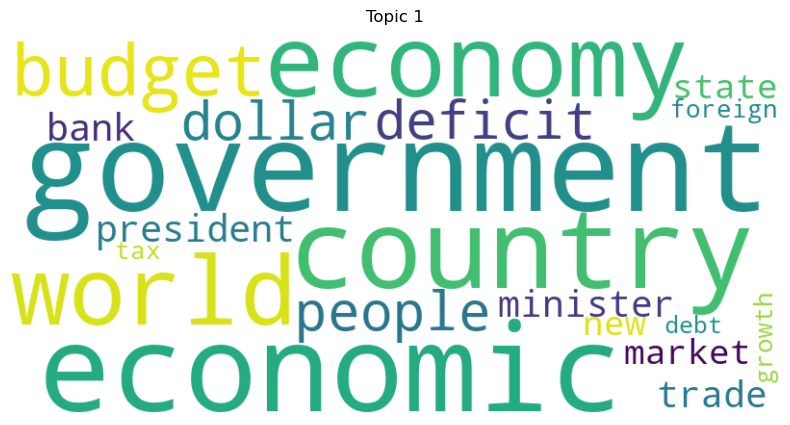

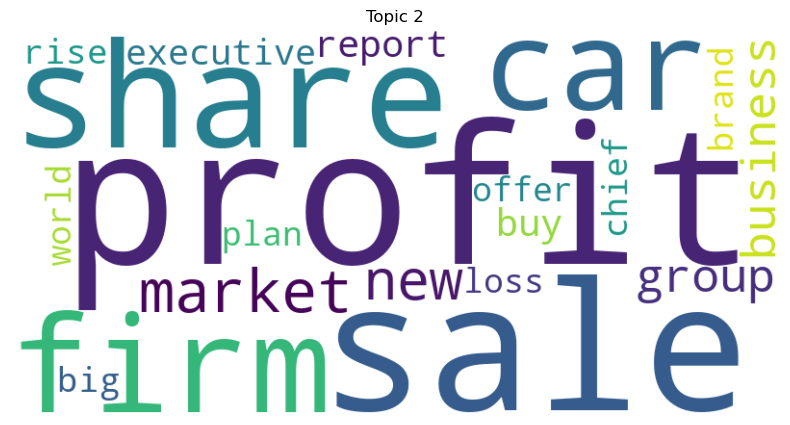

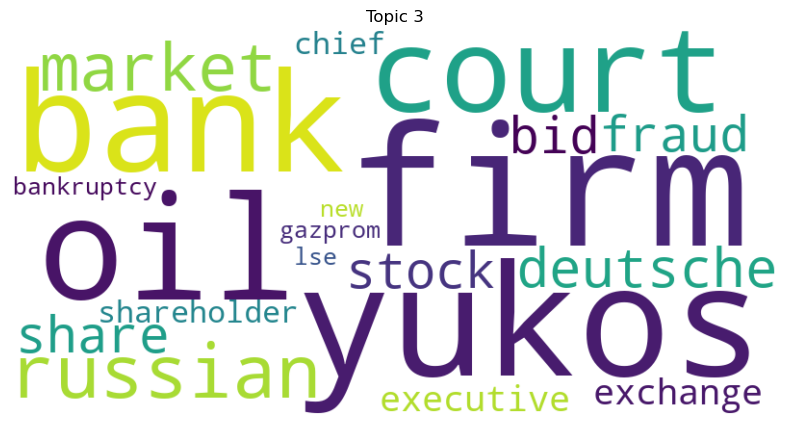

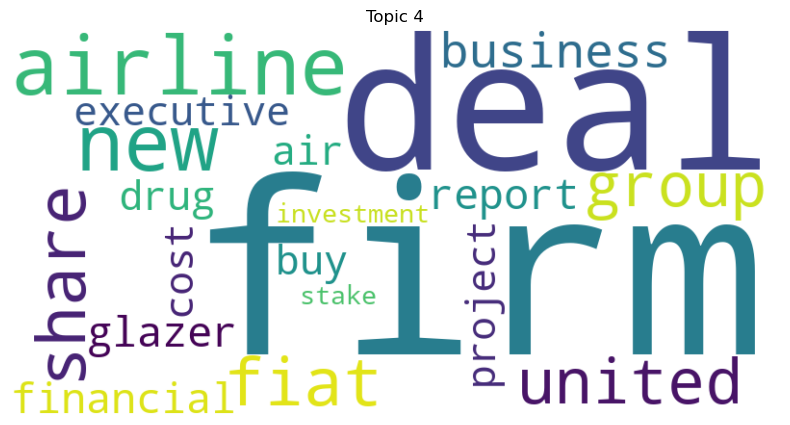

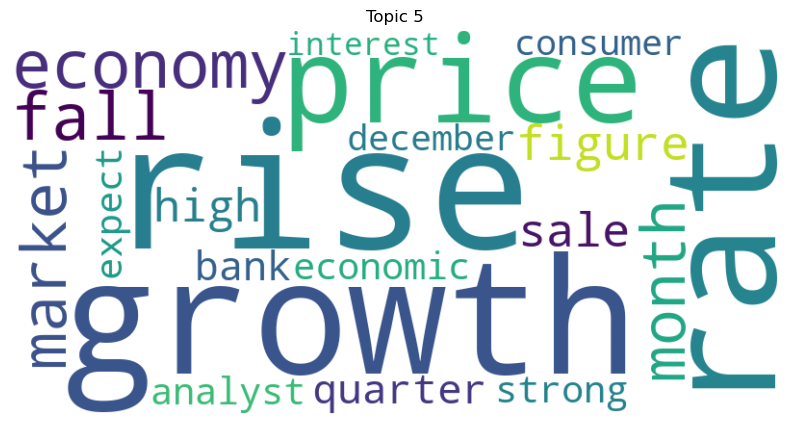


=== Тематическое моделирование для категории: entertainment ===
Топ слова для каждой темы:
Topic 1: 0.011*"festival" + 0.008*"play" + 0.007*"new" + 0.007*"include" + 0.007*"day" + 0.006*"actor" + 0.006*"take" + 0.005*"movie" + 0.005*"singer" + 0.005*"role"
Topic 2: 0.023*"good" + 0.022*"award" + 0.018*"music" + 0.012*"song" + 0.012*"not" + 0.012*"win" + 0.007*"people" + 0.006*"album" + 0.006*"british" + 0.006*"prize"
Topic 3: 0.019*"music" + 0.015*"band" + 0.010*"bbc" + 0.010*"new" + 0.008*"album" + 0.007*"record" + 0.007*"people" + 0.006*"include" + 0.006*"series" + 0.005*"big"
Topic 4: 0.028*"good" + 0.020*"award" + 0.019*"win" + 0.014*"oscar" + 0.013*"number" + 0.013*"actor" + 0.010*"actress" + 0.009*"director" + 0.009*"aviator" + 0.009*"nomination"
Topic 5: 0.013*"book" + 0.011*"sale" + 0.011*"include" + 0.010*"chart" + 0.010*"new" + 0.008*"download" + 0.007*"world" + 0.006*"director" + 0.005*"time" + 0.005*"movie"


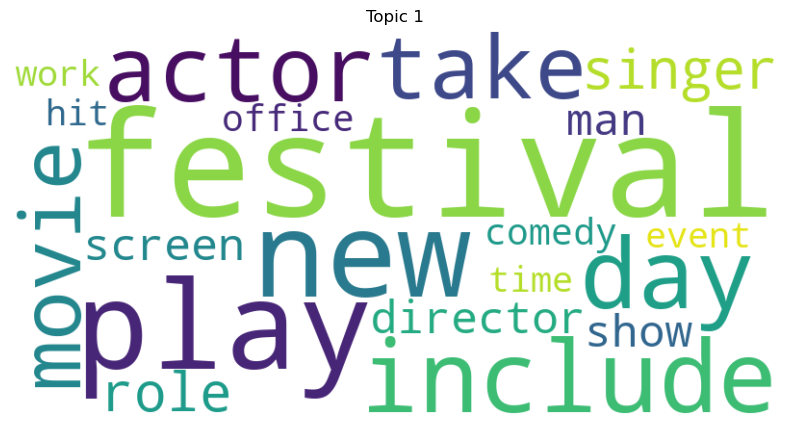

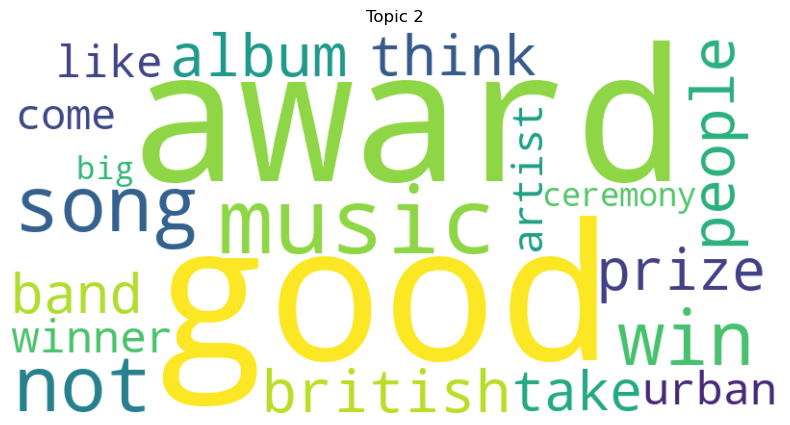

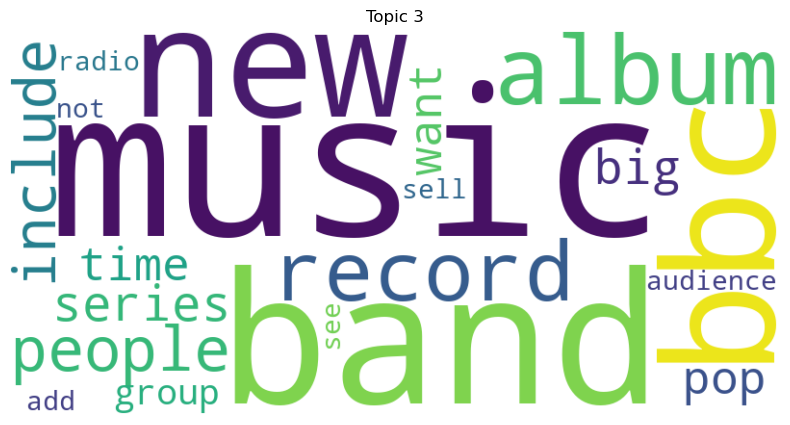

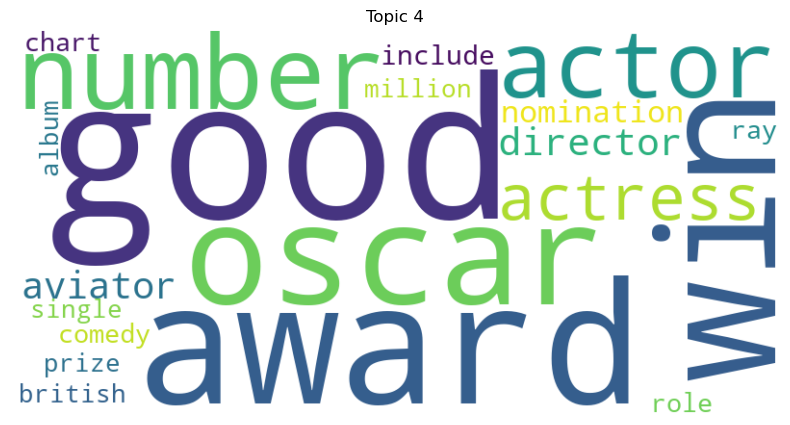

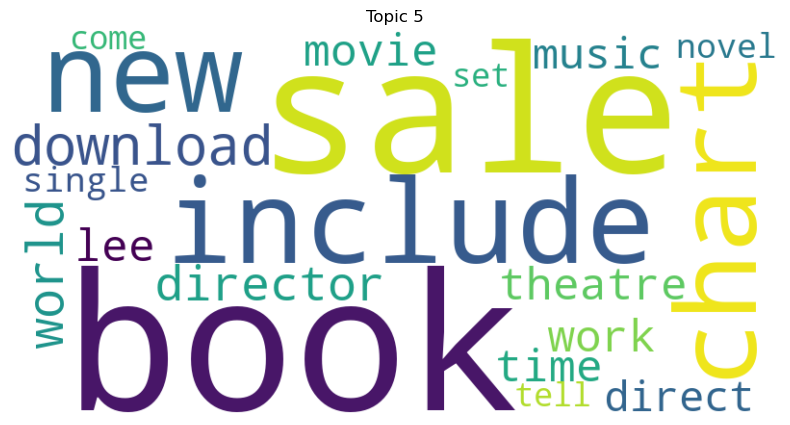


=== Тематическое моделирование для категории: politics ===
Топ слова для каждой темы:
Topic 1: 0.010*"plan" + 0.009*"work" + 0.007*"new" + 0.006*"council" + 0.006*"service" + 0.006*"pay" + 0.006*"child" + 0.005*"increase" + 0.005*"need" + 0.005*"public"
Topic 2: 0.014*"law" + 0.014*"police" + 0.011*"right" + 0.009*"home" + 0.007*"new" + 0.007*"human" + 0.007*"lord" + 0.007*"hunt" + 0.006*"trial" + 0.006*"man"
Topic 3: 0.022*"labour" + 0.018*"election" + 0.018*"tory" + 0.016*"party" + 0.013*"howard" + 0.010*"blair" + 0.008*"plan" + 0.008*"campaign" + 0.007*"vote" + 0.007*"conservative"
Topic 4: 0.020*"brown" + 0.013*"party" + 0.013*"election" + 0.012*"labour" + 0.011*"chancellor" + 0.011*"blair" + 0.008*"tell" + 0.008*"new" + 0.008*"ukip" + 0.007*"tax"
Topic 5: 0.022*"lord" + 0.014*"blair" + 0.007*"prime" + 0.006*"secretary" + 0.006*"tell" + 0.006*"issue" + 0.005*"education" + 0.005*"public" + 0.005*"blunkett" + 0.005*"school"


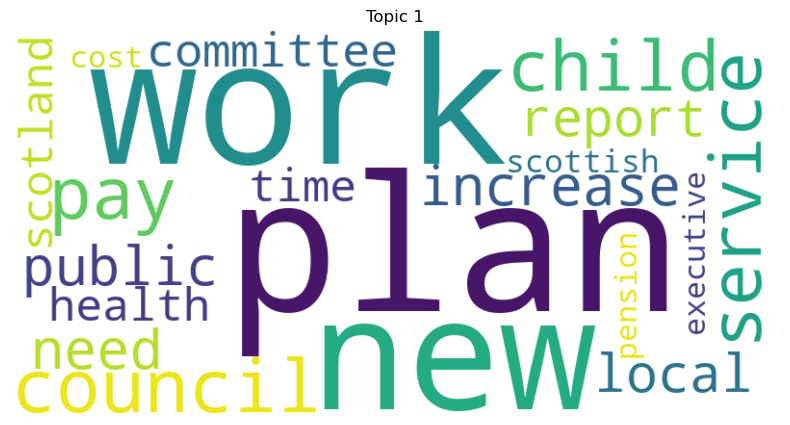

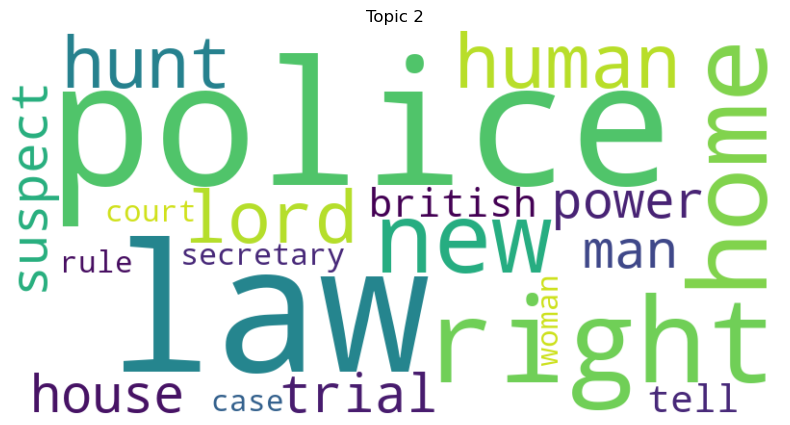

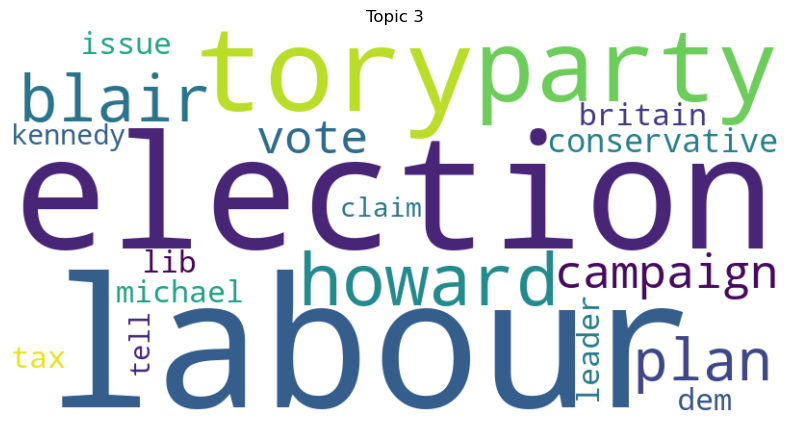

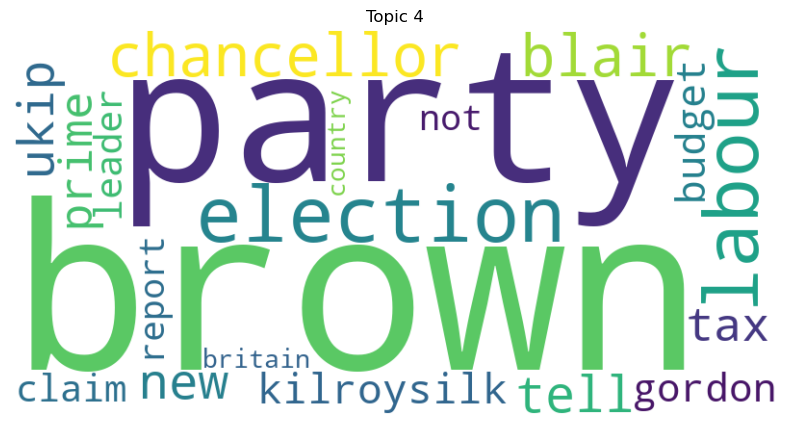

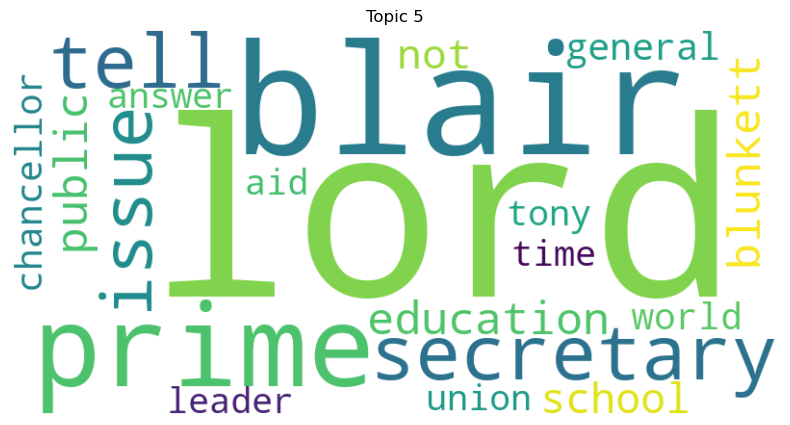


=== Тематическое моделирование для категории: sport ===
Топ слова для каждой темы:
Topic 1: 0.024*"england" + 0.010*"robinson" + 0.010*"player" + 0.009*"rugby" + 0.008*"team" + 0.008*"cup" + 0.008*"world" + 0.008*"year" + 0.008*"new" + 0.007*"ireland"
Topic 2: 0.021*"wale" + 0.013*"ireland" + 0.012*"try" + 0.011*"france" + 0.011*"england" + 0.010*"scotland" + 0.010*"italy" + 0.009*"nation" + 0.009*"williams" + 0.008*"coach"
Topic 3: 0.014*"minute" + 0.010*"goal" + 0.007*"ball" + 0.007*"roddick" + 0.007*"chance" + 0.006*"second" + 0.006*"point" + 0.006*"lead" + 0.006*"arsenal" + 0.006*"player"
Topic 4: 0.012*"world" + 0.011*"year" + 0.009*"olympic" + 0.009*"open" + 0.009*"set" + 0.008*"second" + 0.008*"not" + 0.008*"champion" + 0.008*"final" + 0.007*"good"
Topic 5: 0.013*"club" + 0.012*"not" + 0.010*"player" + 0.009*"good" + 0.008*"chelsea" + 0.008*"want" + 0.008*"league" + 0.008*"think" + 0.008*"liverpool" + 0.007*"time"


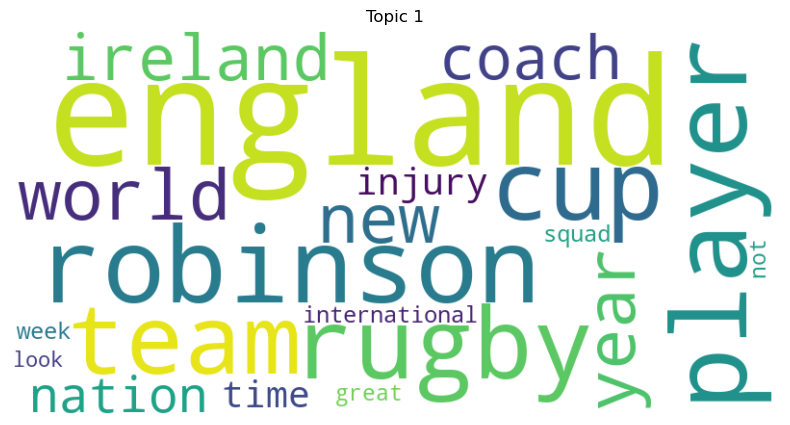

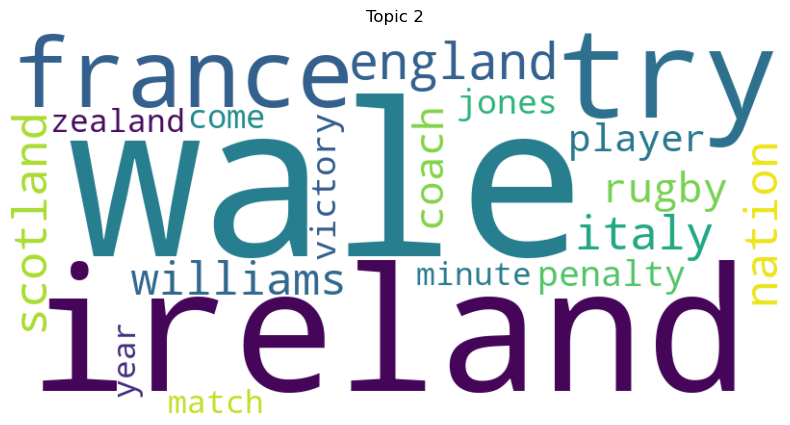

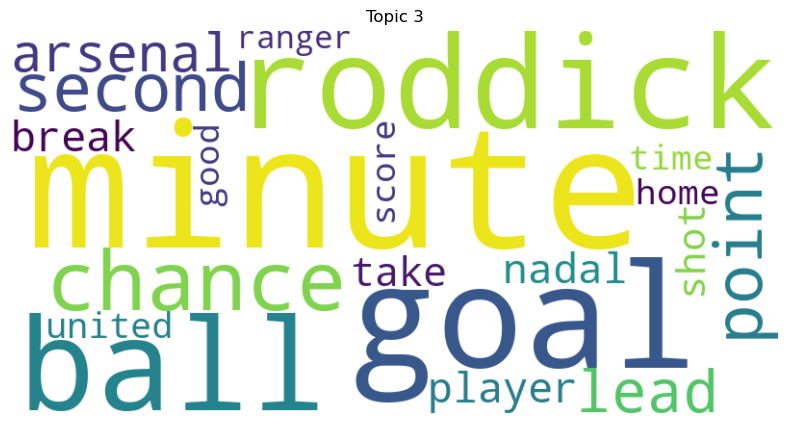

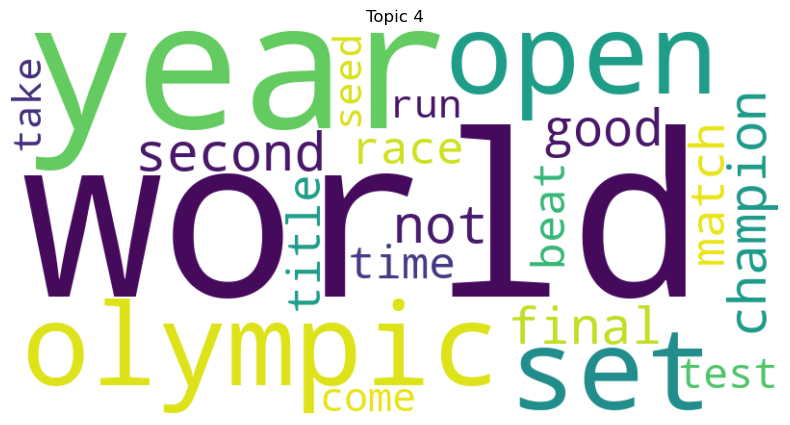

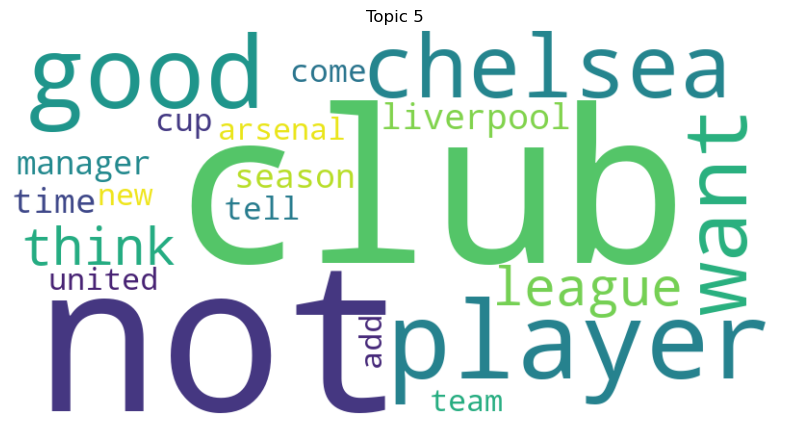


=== Тематическое моделирование для категории: tech ===
Топ слова для каждой темы:
Topic 1: 0.012*"net" + 0.011*"user" + 0.009*"security" + 0.009*"broadband" + 0.009*"service" + 0.008*"virus" + 0.008*"site" + 0.008*"firm" + 0.007*"email" + 0.007*"attack"
Topic 2: 0.014*"gadget" + 0.012*"device" + 0.011*"player" + 0.010*"music" + 0.010*"digital" + 0.010*"sony" + 0.009*"consumer" + 0.009*"apple" + 0.008*"market" + 0.008*"game"
Topic 3: 0.012*"software" + 0.010*"digital" + 0.008*"content" + 0.008*"network" + 0.007*"programme" + 0.007*"company" + 0.007*"file" + 0.006*"film" + 0.006*"microsoft" + 0.006*"service"
Topic 4: 0.033*"mobile" + 0.031*"phone" + 0.013*"service" + 0.008*"camera" + 0.007*"handset" + 0.006*"music" + 0.006*"message" + 0.006*"network" + 0.005*"datum" + 0.005*"video"
Topic 5: 0.029*"game" + 0.011*"search" + 0.008*"online" + 0.007*"site" + 0.007*"time" + 0.006*"like" + 0.006*"play" + 0.006*"website" + 0.006*"user" + 0.005*"look"


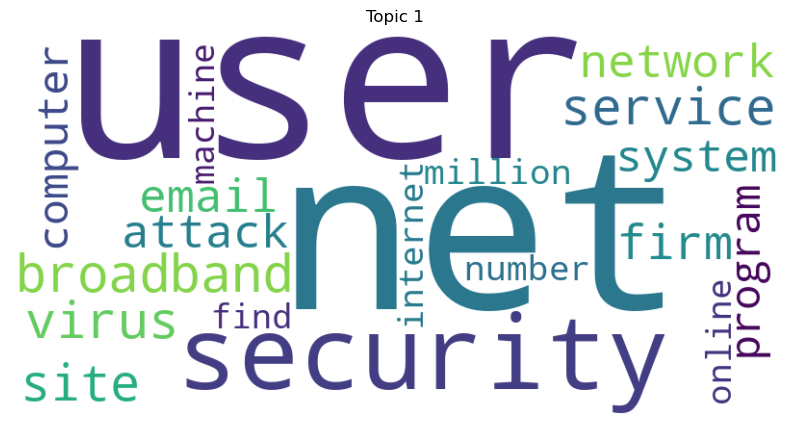

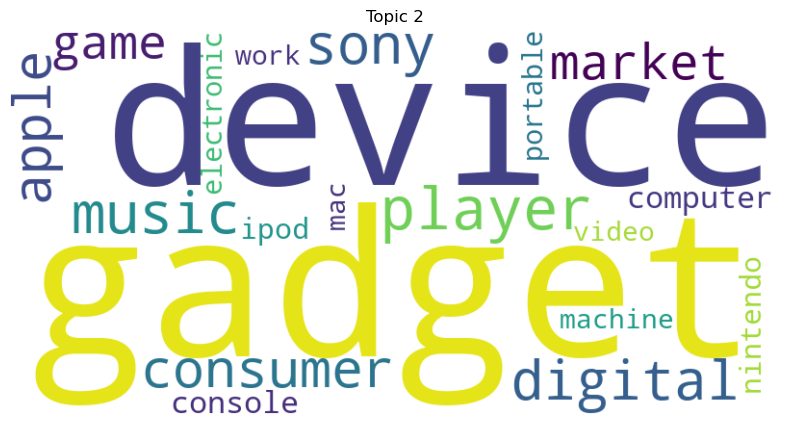

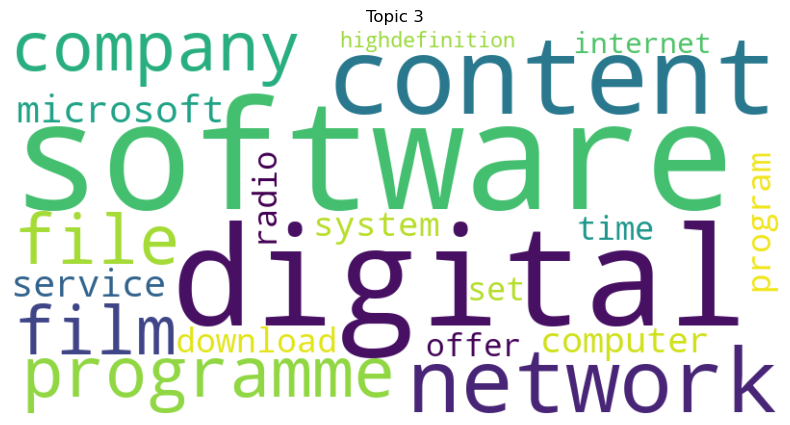

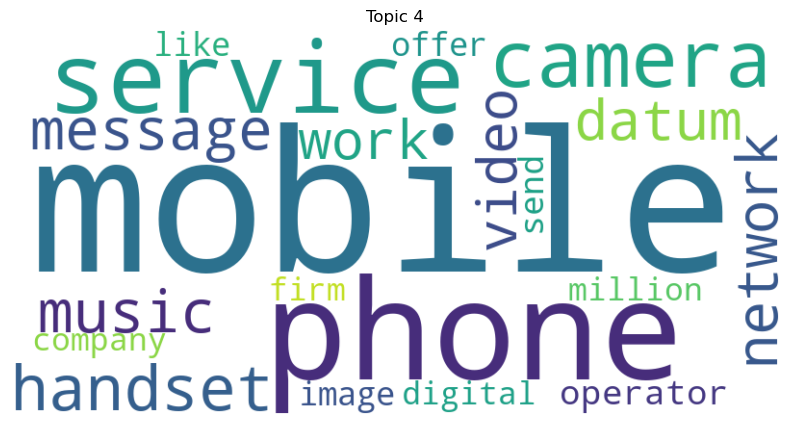

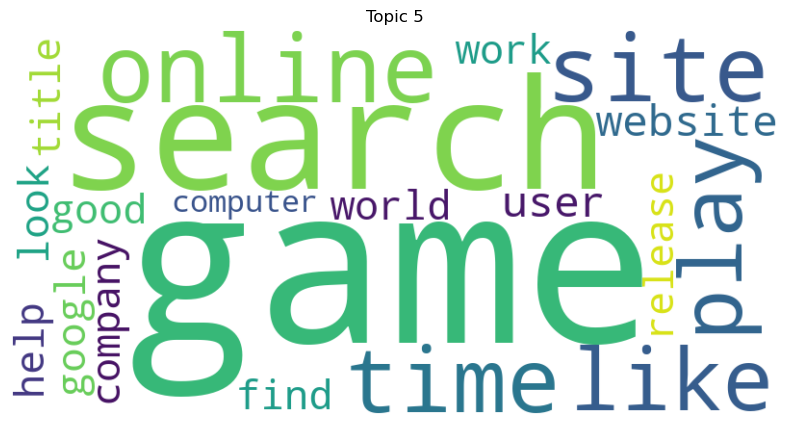

In [13]:
import spacy
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Загружаем модель SpaCy для лемматизации
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Функция для предобработки текста для LDA
def preprocess_text_for_lda(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    doc = nlp(text)
    lemmatized_text = [token.lemma_ for token in doc if not token.is_stop and len(token.lemma_) > 2]
    return lemmatized_text

# Применяем предобработку ко всем текстам
df['tokens'] = df['text'].apply(preprocess_text_for_lda)

# Функция для обучения LDA
def train_lda(tokens, num_topics=5):
    dictionary = corpora.Dictionary(tokens)
    dictionary.filter_extremes(no_below=5, no_above=0.5)  # Удаляем редкие и слишком частые слова
    corpus = [dictionary.doc2bow(token) for token in tokens]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)
    return lda_model, corpus, dictionary

# Визуализация тем с помощью WordCloud
def plot_wordcloud(lda_model, num_topics):
    for i in range(num_topics):
        words = dict(lda_model.show_topic(i, 20))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {i+1}")
        plt.show()

# Визуализация с pyLDAvis
def visualize_lda(lda_model, corpus, dictionary):
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    return pyLDAvis.display(vis)

# Применяем LDA для каждой категории
categories = df['label'].unique()
num_topics = 5

for category in categories:
    print(f"\n=== Тематическое моделирование для категории: {category} ===")
    category_tokens = df[df['label'] == category]['tokens'].tolist()
    if len(category_tokens) < num_topics:
        print(f"Недостаточно данных для категории {category}. Пропускаем.")
        continue
    lda_model, corpus, dictionary = train_lda(category_tokens, num_topics)
    print("Топ слова для каждой темы:")
    for i, topic in lda_model.print_topics():
        print(f"Topic {i+1}: {topic}")
    plot_wordcloud(lda_model, num_topics)
    visualize_lda(lda_model, corpus, dictionary)